In [1]:
import torch
torch.cuda.is_available()
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import keras
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset
import random
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# Define the model architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(262144 , num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Define the iCaRL class
class iCaRL:
    def __init__(self, device, num_classes, batch_size, memory_size):
        self.device = device
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.memory_size = memory_size
        self.model = CNN(num_classes).to(device)
        self.exemplar_sets = []

    def train(self, dataset, lr, num_epochs):
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[49, 63], gamma=0.2)

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            scheduler.step()
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    def test(self, dataset, lr, num_epochs):
        dataset = [(transform(inputs), labels) for inputs, labels in tqdm(dataset)]
        test_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(num_epochs):
            self.model.eval()
            running_loss = 0.0
            test_loss = 0.0
            correct = 0.0
            all_preds = []
            all_labels = []
            batch_size = 4
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                pred = outputs.max(1)[1]
                correct += pred.eq(labels).sum().item()
                preds = pred.cpu().numpy()  # Move predictions to CPU
                preds = torch.from_numpy(preds).float().to(self.device)  # Move back to device
                all_preds.extend(preds)
                all_labels.extend(labels)
                running_loss += loss.item()
                test_loss = running_loss / len(dataset)
            # Calculate metrics
            precision = precision_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')
            f1 = f1_score(all_labels, all_preds, average='weighted')

            print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(dataset), 100. * correct / len(dataset)))
            print('Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}\n'.format(precision, recall, f1))

            return 100. * correct / len(labels)


    def construct_exemplar_set(self, dataset, m):
        exemplar_set = []
        class_means = []
        for class_idx in range(self.num_classes):
            class_indices = [idx for idx, (data, label) in enumerate(dataset) if np.array(label) == np.array(class_idx)]
            random.shuffle(class_indices)
            class_indices = class_indices[:m]

            features = []
            for idx in class_indices:
                img, _ = dataset[idx]  # Access data and label directly from the dataset
                img = img.numpy().astype(np.float32) / 255.0
                img = torch.FloatTensor(img).unsqueeze(0).to(self.device)
                feature = self.model.features(img).cpu().squeeze().detach().numpy()
                features.append(feature)
            features = np.array(features)
            class_mean = np.mean(features, axis=0)

            exemplar_set.append(class_mean / np.linalg.norm(class_mean))
            class_means.append(class_mean / np.linalg.norm(class_mean))

        self.exemplar_sets.append(exemplar_set)
        self.class_means = class_means

    def reduce_exemplar_set(self, m):
        for exemplar_set in self.exemplar_sets:
            exemplar_set = exemplar_set[:m]


    def visualize_predictions(self, dataset, num_samples, device="cpu"):
        transform = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
        dataset = [(transform(inputs), labels) for inputs, labels in tqdm(dataset)]
        test_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        self.model.eval()

        counter = 0  # Counter to keep track of the number of samples processed
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                for j in range(inputs.size(0)):
                    if counter < num_samples:  # Process only up to num_samples
                        image = transforms.ToPILImage()(inputs[j].cpu())  # Convert tensor to PIL image
                        predicted_label = torch.argmax(probabilities[j]).item()
                        predicted_prob = probabilities[j][predicted_label].item() * 100  # Convert to percentage
                        actual_label = labels[j].item()
                        # Display image, predicted label, and probability
                        print(f"Image {counter + 1}:")
                        plt.imshow(image)
                        plt.show()
                        print(f"Predicted Label: {predicted_label}, Actual Label: {actual_label}")
                        print(f"Predicted Probability: {predicted_prob:.2f}%")
                        counter += 1
                    else:
                        break  # Break if the desired number of samples has been processed
                if counter >= num_samples:
                    break  # Break if the desired number of samples has been processed

In [3]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

data_dir = '/content/drive/MyDrive/IIIT/Various_datasets/Satelite Image Classification/OG data/Original Data'

def create_train_test_datasets(dataset_dir, split_size):
    # Create ImageFolder dataset
    dataset = datasets.ImageFolder(root=dataset_dir, transform=None)

    # Calculate sizes for train and test datasets
    train_size = int(len(dataset) * split_size)
    test_size = len(dataset) - train_size

    # Split dataset into train and test datasets
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

# Define transformations to convert PIL images to tensors
transform = transforms.Compose([transforms.Resize(256),
    transforms.ToTensor()
    # Add more transformations as needed
])

# Example usage:
split_size = 0.8  # 80% train, 20% test
dataset = datasets.ImageFolder(root=data_dir, transform=None)
train_size = int(len(dataset) * split_size)
test_size = len(dataset) - train_size

# train_dataset, test_dataset = create_train_test_datasets(data_dir, split_size)
train_data, test_data = random_split(dataset, [train_size, test_size])

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/927 [00:00<?, ?it/s]

Training on task 1
Epoch [1/15], Loss: 0.5150
Epoch [2/15], Loss: 0.4161
Epoch [3/15], Loss: 0.3237
Epoch [4/15], Loss: 0.3100
Epoch [5/15], Loss: 0.3063
Epoch [6/15], Loss: 0.2949
Epoch [7/15], Loss: 0.2742
Epoch [8/15], Loss: 0.3159
Epoch [9/15], Loss: 0.2533
Epoch [10/15], Loss: 0.2479
Epoch [11/15], Loss: 0.2405
Epoch [12/15], Loss: 0.2539
Epoch [13/15], Loss: 0.2224
Epoch [14/15], Loss: 0.2376
Epoch [15/15], Loss: 0.2309
Constructing exemplar set for task 1
Training on task 2
Epoch [1/15], Loss: 0.2589
Epoch [2/15], Loss: 0.2516
Epoch [3/15], Loss: 0.2121
Epoch [4/15], Loss: 0.2265
Epoch [5/15], Loss: 0.2278
Epoch [6/15], Loss: 0.2317
Epoch [7/15], Loss: 0.2413
Epoch [8/15], Loss: 0.2137
Epoch [9/15], Loss: 0.2407
Epoch [10/15], Loss: 0.2043
Epoch [11/15], Loss: 0.2621
Epoch [12/15], Loss: 0.2387
Epoch [13/15], Loss: 0.2252
Epoch [14/15], Loss: 0.1922
Epoch [15/15], Loss: 0.1960
Constructing exemplar set for task 2
Reducing exemplar set for task 1


  0%|          | 0/463 [00:00<?, ?it/s]

Test set: Average loss: 0.0306, Accuracy: 413.0/463 (89%)
Precision: 0.9060, Recall: 0.8920, F1 Score: 0.8909



  0%|          | 0/463 [00:00<?, ?it/s]

Image 1:


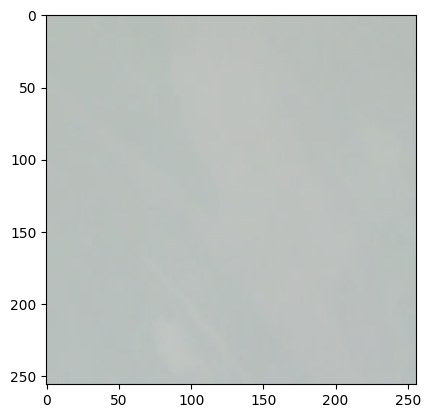

Predicted Label: 0, Actual Label: 0
Predicted Probability: 86.76%
Image 2:


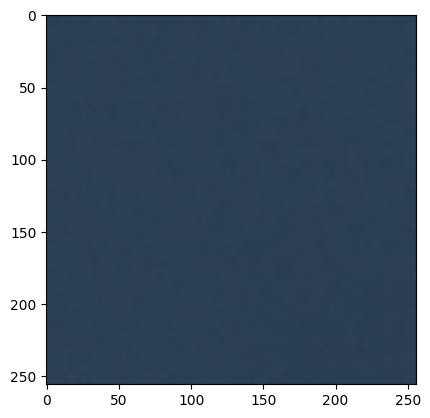

Predicted Label: 2, Actual Label: 3
Predicted Probability: 74.73%
Image 3:


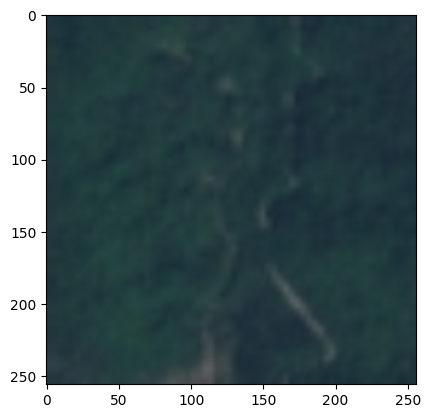

Predicted Label: 2, Actual Label: 2
Predicted Probability: 98.24%
Image 4:


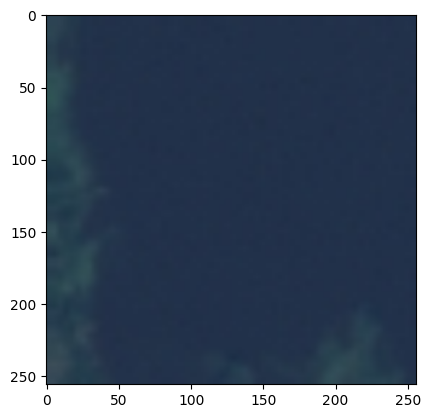

Predicted Label: 3, Actual Label: 3
Predicted Probability: 67.06%
Image 5:


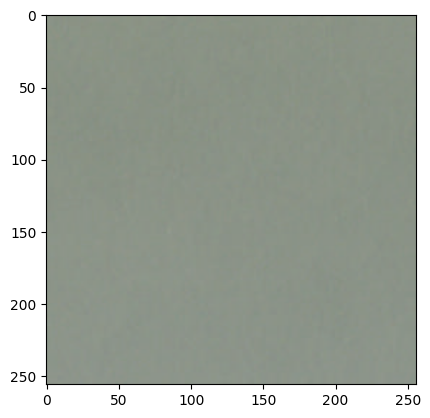

Predicted Label: 0, Actual Label: 0
Predicted Probability: 98.60%


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
num_classes = 4
batch_size = 8
memory_size = 2000
lr = 0.0005
num_epochs = 15
m = memory_size // num_classes

# Initialize iCaRL
icarl = iCaRL(device, num_classes, batch_size, memory_size)

# Define the number of classes to train on for each task
classes_per_task = 2  # You can set this to any number you prefer

from torchvision import transforms

num_tasks = (num_classes + classes_per_task - 1) // classes_per_task
train_datasets = []

# Iterate through each task
for task_idx in range(num_tasks):
    # Calculate the range of classes for the current task
    start_class_idx = task_idx * classes_per_task
    end_class_idx = min(start_class_idx + classes_per_task, num_classes)

    # Filter indices based on the desired class range
    indices = [idx for idx in range(len(train_data)) if start_class_idx <= train_data.dataset.targets[train_data.indices[idx]] < end_class_idx]

    # Create a subset of the original dataset for the current task
    subset = Subset(train_data.dataset, indices)

    # Apply transformations to the subset
    subset = [(transform(sample), target) for sample, target in tqdm(subset)]

    # Add the subset to the list of train datasets
    train_datasets.append(subset)


# Incremental training
for i, train_dataset in enumerate(train_datasets):
    print(f'Training on task {i + 1}')
    icarl.train(train_dataset, lr, num_epochs)
    print(f'Constructing exemplar set for task {i + 1}')
    icarl.construct_exemplar_set(train_dataset, m)
    if i > 0:
        print(f'Reducing exemplar set for task {i}')
        icarl.reduce_exemplar_set(m)

# Evaluation
with torch.no_grad():
  icarl.test(test_data, lr, num_epochs)
  icarl.visualize_predictions(test_data, 5)